# "2-nd step in NLP" competition

В ноутбуке представлен код, написанный в рамках соревнования по NLP на Kaggle: https://www.kaggle.com/competitions/hse-2nd-step-in-nlp-bootcamp/overview

Необходимо предсказать зарплату по описанию вакансии и ряду иных нетекстовых признаков.

Участие принято в формате Late sumbission. По каждой из итоговых 4 моделей указано потенциальное место в соревновании в случае "очного" участия.

### EDA

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = [12, 8]
from tqdm import tqdm
!pip install pymorphy2
from pymorphy2 import MorphAnalyzer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 55.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=752951a8b7526a5a9b359a46f7ab18855744978530c13dd4fcba938d6837781e
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
df_train = pd.read_csv('vacancies_train.csv')
df_train.head()

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0


In [3]:
df_test = pd.read_csv('vacancies_test.csv', index_col=0)
df_test.head()

,name,experience,schedule,employment,description,key_skills
id,,,,,,
0,Главный бухгалтер,Более 6 лет,Полный день,Полная занятость,Обязанности:Осуществление организации бухгалте...,"['1С: Предприятие 8', '1C: Предприятие', 'Рабо..."
1,Ассистент врача-стоматолога,От 1 года до 3 лет,Сменный график,Полная занятость,"Обязанности: Ассистировать врачу стоматологу,...","['Пользователь ПК', 'Работа в команде', 'Умени..."
2,Менеджер по продажам,От 1 года до 3 лет,Полный день,Полная занятость,Если ты: хочешь построить карьеру в банковс...,[]
3,Менеджер,От 1 года до 3 лет,Полный день,Полная занятость,Динамично развивающаяся на протяжении 17 лет...,"['Оценка потребностей клиентов', 'оформление д..."
4,Администратор хостела,Нет опыта,Сменный график,Полная занятость,ВОЗМОЖНА РАБОТА С ПРОЖИВАНИЕМ Обязанности: Пр...,[]


<Axes: xlabel='salary', ylabel='Count'>

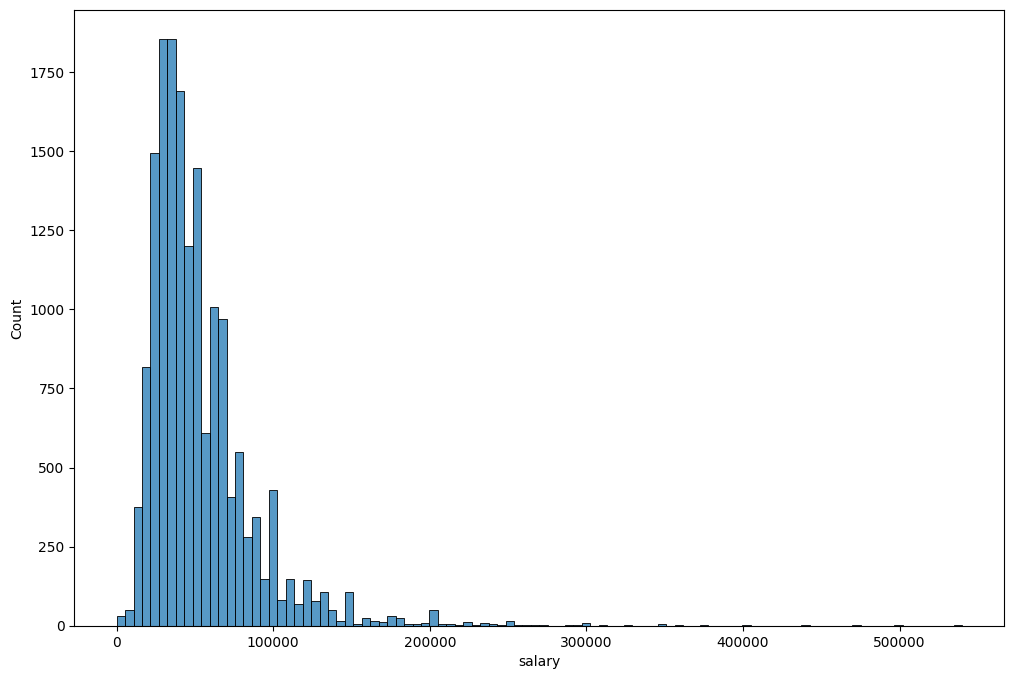

In [4]:
# целевой признак
sns.histplot(df_train['salary'], bins=100)

In [5]:
df_train.isna().sum()

name           0
experience     0
schedule       0
employment     0
description    0
key_skills     0
salary         0
dtype: int64

In [6]:
len(df_train)

16629

In [7]:
len(df_test)

5543

In [8]:
df_train['name'].value_counts()

Менеджер по продажам                                          208
Продавец-консультант                                          180
Менеджер по работе с клиентами                                111
Кладовщик                                                     111
Бухгалтер                                                     108
                                                             ... 
Упаковщица/Упаковщик                                            1
Помощник официанта,ранер                                        1
Менеджер по продаже оборудования для общепита и торговли        1
Электросварщик на полуавтомат (морской регистр, НАКС НГДО)      1
Специалист-эксперт отдела правового обеспечения                 1
Name: name, Length: 9915, dtype: int64

In [9]:
df_test['name'].value_counts()

Менеджер по продажам                                                70
Продавец-консультант                                                65
Кладовщик                                                           51
Менеджер по работе с клиентами                                      36
Медицинская сестра                                                  34
                                                                    ..
Disposal (диспозл)-менеджер по привлечению объектов недвижимости     1
Товаровед-Продавец                                                   1
Слесарь-ремонтник (5 разряд)                                         1
Повар (Камчатский край, Артель)                                      1
Торговый представитель (Колпино, Тосно, Кировск)                     1
Name: name, Length: 3716, dtype: int64

In [10]:
df_train['experience'].value_counts()

Нет опыта             7278
От 1 года до 3 лет    6881
От 3 до 6 лет         2236
Более 6 лет            234
Name: experience, dtype: int64

In [11]:
df_test['experience'].value_counts()

Нет опыта             2460
От 1 года до 3 лет    2270
От 3 до 6 лет          736
Более 6 лет             77
Name: experience, dtype: int64

In [12]:
df_train['schedule'].value_counts()

Полный день         11424
Сменный график       2719
Вахтовый метод       1160
Гибкий график         687
Удаленная работа      639
Name: schedule, dtype: int64

In [13]:
df_test['schedule'].value_counts()

Полный день         3840
Сменный график       912
Вахтовый метод       365
Гибкий график        223
Удаленная работа     203
Name: schedule, dtype: int64

In [14]:
df_train['employment'].value_counts()

Полная занятость       15723
Частичная занятость      803
Проектная работа          67
Стажировка                36
Name: employment, dtype: int64

In [15]:
df_test['employment'].value_counts()

Полная занятость       5233
Частичная занятость     266
Проектная работа         26
Стажировка               18
Name: employment, dtype: int64

In [16]:
len(df_train[df_train['key_skills']=='[]'])

5856

In [17]:
len(df_test[df_test['key_skills']=='[]'])

1955

In [18]:
# просмотр вариантов key skills

from ast import literal_eval
from collections import OrderedDict

skills_count = dict()

for skill_list in df_train.key_skills:
    list_of_skills = literal_eval(skill_list)
    for skill in list_of_skills:
        if skill not in skills_count:
            skills_count[skill] = 1
        else:
            skills_count[skill] += 1

skills_count = {k: v for k, v in sorted(skills_count.items(), key=lambda item: item[1], reverse=True)}
skills_count

{'Работа в команде': 2773,
 'Пользователь ПК': 2638,
 'Грамотная речь': 2226,
 'Умение работать в команде': 1152,
 'Активные продажи': 1066,
 'Деловое общение': 851,
 'Навыки продаж': 700,
 'Телефонные переговоры': 649,
 'Ведение переговоров': 630,
 'Организаторские навыки': 588,
 'Деловая переписка': 523,
 'Клиентоориентированность': 515,
 'Обучение и развитие': 494,
 'Поиск и привлечение клиентов': 479,
 'Грамотность': 462,
 'Работа с большим объемом информации': 420,
 'Прямые продажи': 402,
 'Заключение договоров': 357,
 'Холодные продажи': 352,
 'Ориентация на результат': 349,
 'AutoCAD': 344,
 'Управление персоналом': 342,
 'Консультирование': 340,
 '1С: Предприятие 8': 323,
 'Обучение персонала': 322,
 'Работа с людьми': 304,
 'Водительское удостоверение категории B': 289,
 'Навыки межличностного общения': 283,
 'Деловая коммуникация': 282,
 'Работа с кассой': 278,
 'Знание устройства автомобиля': 275,
 'Медицинская документация': 265,
 'Умение работать в коллективе': 264,
 'Англ

In [19]:
# то же для key skills по тестовой выборке

skills_count_test = dict()

for skill_list in df_test.key_skills:
    list_of_skills = literal_eval(skill_list)
    for skill in list_of_skills:
        if skill not in skills_count_test:
            skills_count_test[skill] = 1
        else:
            skills_count_test[skill] += 1

skills_count_test = {k: v for k, v in sorted(skills_count_test.items(), key=lambda item: item[1], reverse=True)}
skills_count_test

{'Работа в команде': 923,
 'Пользователь ПК': 899,
 'Грамотная речь': 690,
 'Умение работать в команде': 386,
 'Активные продажи': 365,
 'Деловое общение': 253,
 'Навыки продаж': 241,
 'Ведение переговоров': 217,
 'Телефонные переговоры': 200,
 'Организаторские навыки': 193,
 'Обучение и развитие': 184,
 'Поиск и привлечение клиентов': 184,
 'Клиентоориентированность': 173,
 'Грамотность': 166,
 'Деловая переписка': 156,
 'Прямые продажи': 155,
 'Работа с большим объемом информации': 147,
 'Заключение договоров': 143,
 'Холодные продажи': 131,
 'Обучение персонала': 123,
 'Консультирование': 121,
 'Управление персоналом': 121,
 'Водительское удостоверение категории B': 106,
 'Навыки межличностного общения': 106,
 'Ориентация на результат': 105,
 'AutoCAD': 103,
 'Работа с людьми': 101,
 'Знание устройства автомобиля': 99,
 '1С: Предприятие 8': 98,
 'Английский язык': 98,
 'Работа с кассой': 94,
 'Развитие продаж': 92,
 'B2B Продажи': 91,
 'CRM': 85,
 'Медицинская документация': 84,
 'К

### Data preprocessing

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16629 entries, 0 to 16628
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         16629 non-null  object 
 1   experience   16629 non-null  object 
 2   schedule     16629 non-null  object 
 3   employment   16629 non-null  object 
 4   description  16629 non-null  object 
 5   key_skills   16629 non-null  object 
 6   salary       16629 non-null  float64
dtypes: float64(1), object(6)
memory usage: 909.5+ KB


In [21]:
def words_only(text):
    '''
    убираем ссылки, токенизируем, возвращаем строку
    '''
    try:
        text_no_links = re.sub(r'http\S+', '', text)
        text_no_links = re.sub('[^а-яёА-ЯЁa-zA-Z]', ' ', text_no_links)
        return ' '.join(word_tokenize(text_no_links.lower()))
    except:
        return ''

tqdm.pandas()
df_train['name'] = (df_train['name'].str.lower()).progress_apply(words_only)

mystopwords = set(stopwords.words('russian'))

def remove_stopwords(text, mystopwords = mystopwords):
    '''
    удаление стоп-слов
    '''
    try:
        return ' '.join([token for token in text.split() if not token in mystopwords])
    except:
        return ''

df_train['name'] = df_train['name'].progress_apply(remove_stopwords)

m = MorphAnalyzer()

def lemmatize(text, morph=m):
    '''
    лемматизация с удалением коротких слов
    '''
    try:
        return ' '.join([morph.parse(word)[0].normal_form for word in text.split() if len(word) >= 4])
    except:
        return ' '

df_train['name'] = df_train['name'].progress_apply(lemmatize)

df_train.head()

100%|██████████| 16629/16629 [00:18<00:00, 903.37it/s]


,name,experience,schedule,employment,description,key_skills,salary
0,водитель экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,кладовщик комплектовщик оператор,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,продавец магазин магнит кировский,Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0
3,администратор магазин spar,От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0
4,мойщик посуда кулинария,Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0


In [22]:
# такая же обработка для поля description
df_train['description'] = (df_train['description'].str.lower()).progress_apply(words_only)
df_train['description'] = df_train['description'].progress_apply(remove_stopwords)
df_train['description'] = df_train['description'].progress_apply(lemmatize)
df_train.head()

100%|██████████| 16629/16629 [05:42<00:00, 48.49it/s]


,name,experience,schedule,employment,description,key_skills,salary
0,водитель экспедитор,От 3 до 6 лет,Полный день,Полная занятость,водитель экспедитор категория газель тент газе...,[],42500.0
1,кладовщик комплектовщик оператор,От 1 года до 3 лет,Полный день,Полная занятость,обязанность списывание материал производство п...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,продавец магазин магнит кировский,Нет опыта,Сменный график,Полная занятость,крупный федеральный сеть магазин магнит требов...,[],31500.0
3,администратор магазин spar,От 1 года до 3 лет,Полный день,Полная занятость,крупный федеральный сеть магазин мужской женск...,[],36700.0
4,мойщик посуда кулинария,Нет опыта,Сменный график,Полная занятость,обязанность уборка производственный площадь ку...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0


In [23]:
df_train_lemmatized = df_train.copy(deep=True)

In [24]:
# df_train = df_train_lemmatized.copy()   # если надо начать с этого чекпойнта

In [25]:
# признак experience - логичная зависимость от опыта в годах
# можно обойтись без ohe-кодирования
# примем 0 для "нет опыта", 1 - для опыта 1-3 года, 2 - 3-6 лет, 3 - более 6 лет

def encode_experience(exp):
    exp_dict = {
                'Нет опыта': 0,
                'От 1 года до 3 лет': 1,
                'От 3 до 6 лет': 2,
                'Более 6 лет': 3
                }
    try:
        return exp_dict[exp]
    except:
        return 0

df_train['experience'] = df_train['experience'].apply(encode_experience)
df_train.head()

,name,experience,schedule,employment,description,key_skills,salary
0,водитель экспедитор,2,Полный день,Полная занятость,водитель экспедитор категория газель тент газе...,[],42500.0
1,кладовщик комплектовщик оператор,1,Полный день,Полная занятость,обязанность списывание материал производство п...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,продавец магазин магнит кировский,0,Сменный график,Полная занятость,крупный федеральный сеть магазин магнит требов...,[],31500.0
3,администратор магазин spar,1,Полный день,Полная занятость,крупный федеральный сеть магазин мужской женск...,[],36700.0
4,мойщик посуда кулинария,0,Сменный график,Полная занятость,обязанность уборка производственный площадь ку...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0


In [26]:
# # признак schedule - используем one-hot encoding (dummies)
# dummy_schedule = pd.get_dummies(df_train['schedule'])
# dummy_schedule.head()
# df_train = df_train.join(dummy_schedule)
# df_train.drop('schedule', axis=1, inplace=True)
# df_train.head()

In [27]:
# # признак employment - используем one-hot encoding (dummies)
# dummy_employment = pd.get_dummies(df_train['employment'])
# dummy_employment.head()
# df_train = df_train.join(dummy_employment)
# df_train.drop('employment', axis=1, inplace=True)
# df_train.head()

In [28]:
# признак key skills - вычислим количество скиллов

def get_nof_skills(text):
    return text.strip('[]').split(', ')

df_train['key_skills'] = df_train['key_skills'].apply(get_nof_skills)

df_train['key_skills'] = df_train['key_skills'].apply(lambda x: len(x))

df_train.head()

,name,experience,schedule,employment,description,key_skills,salary
0,водитель экспедитор,2,Полный день,Полная занятость,водитель экспедитор категория газель тент газе...,1,42500.0
1,кладовщик комплектовщик оператор,1,Полный день,Полная занятость,обязанность списывание материал производство п...,11,50000.0
2,продавец магазин магнит кировский,0,Сменный график,Полная занятость,крупный федеральный сеть магазин магнит требов...,1,31500.0
3,администратор магазин spar,1,Полный день,Полная занятость,крупный федеральный сеть магазин мужской женск...,1,36700.0
4,мойщик посуда кулинария,0,Сменный график,Полная занятость,обязанность уборка производственный площадь ку...,5,37000.0


In [29]:
# проведем ту же предобработку тестовой выборки

df_test['name'] = (df_test['name'].str.lower()).progress_apply(words_only)
df_test['name'] = df_test['name'].progress_apply(remove_stopwords)
df_test['name'] = df_test['name'].progress_apply(lemmatize)

df_test['description'] = (df_test['description'].str.lower()).progress_apply(words_only)
df_test['description'] = df_test['description'].progress_apply(remove_stopwords)
df_test['description'] = df_test['description'].progress_apply(lemmatize)

df_test_lemmatized = df_test.copy(deep=True)
df_test['experience'] = df_test['experience'].apply(encode_experience)

# dummy_schedule = pd.get_dummies(df_test['schedule'])
# df_test = df_test.join(dummy_schedule)
# df_test.drop('schedule', axis=1, inplace=True)

# dummy_employment = pd.get_dummies(df_test['employment'])
# df_test = df_test.join(dummy_employment)
# df_test.drop('employment', axis=1, inplace=True)

df_test['key_skills'] = df_test['key_skills'].apply(get_nof_skills)
df_test['key_skills'] = df_test['key_skills'].apply(lambda x: len(x))

df_test.head()

100%|██████████| 5543/5543 [01:51<00:00, 49.90it/s]


,name,experience,schedule,employment,description,key_skills
id,,,,,,
0,главный бухгалтер,3,Полный день,Полная занятость,обязанность осуществление организация бухгалте...,5
1,ассистент врач стоматолог,1,Сменный график,Полная занятость,обязанность ассистировать врач стоматолог подг...,4
2,менеджер продажа,1,Полный день,Полная занятость,хотеть построить карьера банковский сектор ори...,1
3,менеджер,1,Полный день,Полная занятость,динамично развивающийся протяжение компания им...,12
4,администратор хостел,0,Сменный график,Полная занятость,возможный работа проживание обязанность приём ...,1


### v1 - BOW Baseline

In [30]:
df_train.head(1)

,name,experience,schedule,employment,description,key_skills,salary
0,водитель экспедитор,2,Полный день,Полная занятость,водитель экспедитор категория газель тент газе...,1,42500.0


In [31]:
# для целей предварительной оценки качества различных моделей разделим обучающую выборку на train и test части

from sklearn.model_selection import train_test_split

X = df_train[['name', 'experience', 'description', 'key_skills', 'schedule', 'employment']]

y = df_train['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

13303
3326
13303
3326


In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

# классы для обработки текстовых и иных признаков

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

text1 = Pipeline([
    ('selector', TextSelector(key='name')),
    ('cnt_vect', CountVectorizer(ngram_range=(1, 1)))
])

text1.fit_transform(X_train)

<13303x4574 sparse matrix of type '<class 'numpy.int64'>'
	with 39803 stored elements in Compressed Sparse Row format>

In [34]:
text2 = Pipeline([
    ('selector', TextSelector(key='description')),
    ('cnt_vect', CountVectorizer(ngram_range=(1, 1)))
])

text2.fit_transform(X_train)

<13303x29492 sparse matrix of type '<class 'numpy.int64'>'
	with 1065889 stored elements in Compressed Sparse Row format>

In [35]:
from sklearn.preprocessing import MinMaxScaler

exp = Pipeline([
    ('selector', ItemSelector(key='experience')),
    ('mm_scaler', MinMaxScaler())
])

exp.fit_transform(X_train)

array([[0.        ],
       [0.        ],
       [0.66666667],
       ...,
       [1.        ],
       [0.        ],
       [0.33333333]])

In [36]:
skls = Pipeline([
    ('selector', ItemSelector(key='key_skills')),
    ('mm_scaler', MinMaxScaler())
])

skls.fit_transform(X_train)

array([[0.        ],
       [0.10344828],
       [0.        ],
       ...,
       [0.13793103],
       [0.        ],
       [0.10344828]])

In [37]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

schdl = Pipeline([
    ('selector', ItemSelector(key='schedule')),
    ('ohe', OneHotEncoder(categories=[X_train['schedule'].unique()]))
])

schdl.fit_transform(X_train)

<13303x5 sparse matrix of type '<class 'numpy.float64'>'
	with 13303 stored elements in Compressed Sparse Row format>

In [38]:
empl = Pipeline([
    ('selector', ItemSelector(key='employment')),
    ('ohe', OneHotEncoder(categories=[X_train['employment'].unique()]))
])

empl.fit_transform(X_train)

<13303x4 sparse matrix of type '<class 'numpy.float64'>'
	with 13303 stored elements in Compressed Sparse Row format>

In [39]:
from sklearn.pipeline import FeatureUnion

features1 = FeatureUnion([
    ('text1', text1),
    ('text2', text2),
    ('experience', exp),
    ('key skills', skls),
    ('schedule', schdl),
    ('employment', empl)
])

In [40]:
from sklearn.ensemble import RandomForestRegressor as rf

pipe_1 = Pipeline([
    ('features', features1),
    ('rf', rf(n_estimators=30, criterion='squared_error', max_depth=10, min_samples_leaf=5))
])

pipe_1.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text1',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='name')),
                                                                 ('cnt_vect',
                                                                  CountVectorizer())])),
                                                ('text2',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='description')),
                                                                 ('cnt_vect',
                                                                  CountVectorizer())])),
                                                ('experience',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='experience')),
                                                                 ('mm_scaler',
                                                                  Min...
                                                                  OneHotEncoder(categories=[array(['Сменный график', 'Полный день', 'Вахтовый метод',
       'Удаленная работа', 'Гибкий график'], dtype=object)]))])),
                                                ('employment',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='employment')),
                                                                 ('ohe',
                                                                  OneHotEncoder(categories=[array(['Полная занятость', 'Частичная занятость', 'Стажировка',
       'Проектная работа'], dtype=object)]))]))])),
                ('rf',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=5,
                                       n_estimators=30))])

In [41]:
preds_1 = pipe_1.predict(X_test)

In [42]:
# предварительная оценка метрик R2 и MAE

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
r2_m1 = r2_score(y_test, preds_1)
print(r2_m1)
mae_m1 = mae(y_test, preds_1)
print(mae_m1)

0.394814509756929
17863.636568352915


In [43]:
# визуальное сравнение целевых значений и предсказаний

pd.DataFrame({'original test': y_test, 'predictions': preds_1})

,original test,predictions
4506,53000.0,37710.878406
13781,50000.0,37996.005053
15903,33000.0,46959.157987
9515,50000.0,52622.501275
4800,50000.0,64953.959296
...,...,...
1924,52500.0,44733.589327
2029,45500.0,46959.157987
8406,30000.0,33452.437832
820,29500.0,38023.057374


In [44]:
from sklearn.linear_model import Ridge

pipe_1v2 = Pipeline([
    ('features', features1),
    ('ridge', Ridge(max_iter=500))
])

pipe_1v2.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text1',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='name')),
                                                                 ('cnt_vect',
                                                                  CountVectorizer())])),
                                                ('text2',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='description')),
                                                                 ('cnt_vect',
                                                                  CountVectorizer())])),
                                                ('experience',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='experience')),
                                                                 ('mm_scaler',
                                                                  Min...
                                                                  OneHotEncoder(categories=[array(['Сменный график', 'Полный день', 'Вахтовый метод',
       'Удаленная работа', 'Гибкий график'], dtype=object)]))])),
                                                ('employment',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='employment')),
                                                                 ('ohe',
                                                                  OneHotEncoder(categories=[array(['Полная занятость', 'Частичная занятость', 'Стажировка',
       'Проектная работа'], dtype=object)]))]))])),
                ('ridge', Ridge(max_iter=500))])

In [45]:
preds_1v2 = pipe_1v2.predict(X_test)

In [46]:
r2_m1v2 = r2_score(y_test, preds_1v2)
print(r2_m1v2)
mae_m1v2 = mae(y_test, preds_1v2)
print(mae_m1v2)

0.1413100230482619
21733.673815596358


In [47]:
pd.DataFrame({'original test': y_test, 'predictions': preds_1v2})

,original test,predictions
4506,53000.0,50850.444934
13781,50000.0,76023.188278
15903,33000.0,28151.838190
9515,50000.0,97845.330961
4800,50000.0,63263.264639
...,...,...
1924,52500.0,56859.288132
2029,45500.0,32162.894016
8406,30000.0,36170.088349
820,29500.0,61960.553594


### v2 - TF-IDF Baseline

In [48]:
# те же модели и параметры, но с TF-IDF вместо CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

X = df_train[['name', 'experience', 'description', 'key_skills', 'schedule', 'employment']]
y = df_train['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

text1 = Pipeline([
    ('selector', TextSelector(key='name')),
    ('cnt_vect', TfidfVectorizer(ngram_range=(1, 1)))
])

text1.fit_transform(X_train)

text2 = Pipeline([
    ('selector', TextSelector(key='description')),
    ('cnt_vect', TfidfVectorizer(ngram_range=(1, 1)))
])

text2.fit_transform(X_train)

exp = Pipeline([
    ('selector', ItemSelector(key='experience')),
    ('mm_scaler', MinMaxScaler())
])

exp.fit_transform(X_train)

skls = Pipeline([
    ('selector', ItemSelector(key='key_skills')),
    ('mm_scaler', MinMaxScaler())
])

skls.fit_transform(X_train)

schdl = Pipeline([
    ('selector', ItemSelector(key='schedule')),
    ('ohe', OneHotEncoder(categories=[X_train['schedule'].unique()]))
])

schdl.fit_transform(X_train)

empl = Pipeline([
    ('selector', ItemSelector(key='employment')),
    ('ohe', OneHotEncoder(categories=[X_train['employment'].unique()]))
])

empl.fit_transform(X_train)

<13303x4 sparse matrix of type '<class 'numpy.float64'>'
	with 13303 stored elements in Compressed Sparse Row format>

In [49]:
from sklearn.pipeline import FeatureUnion

features2 = FeatureUnion([
    ('text1', text1),
    ('text2', text2),
    ('experience', exp),
    ('key skills', skls),
    ('schedule', schdl),
    ('employment', empl)
])

In [50]:
pipe_2 = Pipeline([
    ('features', features2),
    ('rf', rf(n_estimators=30, criterion='squared_error', max_depth=10, min_samples_leaf=5))
])

pipe_2.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text1',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='name')),
                                                                 ('cnt_vect',
                                                                  TfidfVectorizer())])),
                                                ('text2',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='description')),
                                                                 ('cnt_vect',
                                                                  TfidfVectorizer())])),
                                                ('experience',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='experience')),
                                                                 ('mm_scaler',
                                                                  Min...
                                                                  OneHotEncoder(categories=[array(['Сменный график', 'Полный день', 'Вахтовый метод',
       'Удаленная работа', 'Гибкий график'], dtype=object)]))])),
                                                ('employment',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='employment')),
                                                                 ('ohe',
                                                                  OneHotEncoder(categories=[array(['Полная занятость', 'Частичная занятость', 'Стажировка',
       'Проектная работа'], dtype=object)]))]))])),
                ('rf',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=5,
                                       n_estimators=30))])

In [51]:
preds_2 = pipe_2.predict(X_test)

In [52]:
# предварительная оценка метрик R2 и MAE

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
r2_m2 = r2_score(y_test, preds_2)
print(r2_m2)
mae_m2 = mae(y_test, preds_2)
print(mae_m2)

0.3776880890478539
17977.422248600204


In [53]:
pipe_2v2 = Pipeline([
    ('features', features2),
    ('ridge', Ridge(max_iter=500))
])

pipe_2v2.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text1',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='name')),
                                                                 ('cnt_vect',
                                                                  TfidfVectorizer())])),
                                                ('text2',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='description')),
                                                                 ('cnt_vect',
                                                                  TfidfVectorizer())])),
                                                ('experience',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='experience')),
                                                                 ('mm_scaler',
                                                                  Min...
                                                                  OneHotEncoder(categories=[array(['Сменный график', 'Полный день', 'Вахтовый метод',
       'Удаленная работа', 'Гибкий график'], dtype=object)]))])),
                                                ('employment',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='employment')),
                                                                 ('ohe',
                                                                  OneHotEncoder(categories=[array(['Полная занятость', 'Частичная занятость', 'Стажировка',
       'Проектная работа'], dtype=object)]))]))])),
                ('ridge', Ridge(max_iter=500))])

In [54]:
preds_2v2 = pipe_2v2.predict(X_test)

In [55]:
r2_m2v2 = r2_score(y_test, preds_2v2)
print(r2_m2v2)
mae_m2v2 = mae(y_test, preds_2v2)
print(mae_m2v2)

0.5010378192740952
16452.46634894605


In [56]:
pd.DataFrame({'original test': y_test, 'predictions': preds_2v2})

,original test,predictions
4506,53000.0,48938.314843
13781,50000.0,72570.214080
15903,33000.0,39967.492710
9515,50000.0,64117.948645
4800,50000.0,67308.194731
...,...,...
1924,52500.0,44635.722552
2029,45500.0,26208.423532
8406,30000.0,35165.161082
820,29500.0,38440.244759


### v3 - Word2Vec Baseline

In [57]:
from gensim.models import Word2Vec

In [58]:
# 1 вариант - обучение на словах из датасета (train)

w2v_model = Word2Vec(sentences=list(X_train['description'].str.split()),
                     vector_size=100, window=7, workers=4, min_count=10)

In [59]:
w2v_vectors = w2v_model.wv
w2v_vectors['менеджер']

array([ 0.51817364, -3.3120058 ,  1.3949229 , -1.5928127 ,  0.16851479,
        2.399731  , -1.7981807 , -1.5254898 ,  0.95792097, -1.7171454 ,
        0.33159038, -0.7335911 , -0.46204665,  0.9046366 ,  1.1472528 ,
        1.1559178 ,  1.3885818 ,  0.9346827 , -0.87567294, -0.78682584,
       -0.2782902 , -2.5343266 , -1.2483044 , -0.8639461 , -0.20748685,
        0.6842409 ,  0.2353315 ,  0.06312508,  0.5873045 , -0.8870796 ,
       -1.132178  ,  0.5505407 , -0.646059  , -1.1199274 , -0.17789863,
        0.9050365 ,  2.5422878 ,  0.45594847,  3.3095202 ,  1.2936287 ,
        2.2777555 ,  0.27222466, -0.8038497 , -0.61525196,  0.64953977,
       -0.7459877 , -0.43544874,  2.6827915 ,  0.8122731 ,  1.0175167 ,
       -0.52420604, -0.33189455, -0.03591264, -0.2634024 , -1.2159146 ,
        3.386325  ,  0.17725404,  1.3478942 , -0.3498923 , -2.1139748 ,
        1.5050329 ,  1.4284241 ,  1.129088  , -0.3928478 ,  0.9587164 ,
        2.7965264 ,  0.53320295,  0.026902  , -0.4212367 , -1.20

In [60]:
doc_vectors_train = []
row = 0

for doc in tqdm(X_train['description'].str.split()):
    res = np.zeros(100)
    cnt = 0
    for word in doc:
        if w2v_vectors.__contains__(word):
            res += w2v_model.wv[word]
            cnt += 1
    if cnt != 0:
        res /= cnt
    doc_vectors_train.append(res)

doc_vectors_train = np.array(doc_vectors_train)

100%|██████████| 13303/13303 [00:11<00:00, 1169.51it/s]


In [61]:
doc_vectors_test = []
row = 0

for doc in tqdm(X_test['description'].str.split()):
    res = np.zeros(100)
    cnt = 0
    for word in doc:
        if w2v_vectors.__contains__(word):
            res += w2v_model.wv[word]
            cnt += 1
    if cnt != 0:
        res /= cnt
    doc_vectors_test.append(res)

doc_vectors_test = np.array(doc_vectors_test)

100%|██████████| 3326/3326 [00:01<00:00, 3088.13it/s]


In [62]:
from sklearn.ensemble import RandomForestRegressor as rf

rfc = rf(n_estimators=30, criterion='squared_error', max_depth=10, min_samples_leaf=5)

model_3 = rfc.fit(doc_vectors_train, np.array(y_train))

In [63]:
preds_3 = model_3.predict(doc_vectors_test)

In [64]:
r2_m3 = r2_score(y_test, preds_3)
print(r2_m3)
mae_m3 = mae(y_test, preds_3)
print(mae_m3)

0.321928843869848
18641.117588294914


In [65]:
pd.DataFrame({'original test': y_test, 'predictions': preds_3})

,original test,predictions
4506,53000.0,45117.840767
13781,50000.0,47649.181688
15903,33000.0,32197.818800
9515,50000.0,44988.128165
4800,50000.0,80911.171444
...,...,...
1924,52500.0,53482.089919
2029,45500.0,38395.431447
8406,30000.0,35372.304084
820,29500.0,32993.647039


In [66]:
X.head()

,name,experience,description,key_skills,schedule,employment
0,водитель экспедитор,2,водитель экспедитор категория газель тент газе...,1,Полный день,Полная занятость
1,кладовщик комплектовщик оператор,1,обязанность списывание материал производство п...,11,Полный день,Полная занятость
2,продавец магазин магнит кировский,0,крупный федеральный сеть магазин магнит требов...,1,Сменный график,Полная занятость
3,администратор магазин spar,1,крупный федеральный сеть магазин мужской женск...,1,Полный день,Полная занятость
4,мойщик посуда кулинария,0,обязанность уборка производственный площадь ку...,5,Сменный график,Полная занятость


In [67]:
# Второй вариант - векторная модель с измененными параметрами + учет прочих признаков

# для начала ohe-кодируем признаки schedule и employment

dummy_schedule = pd.get_dummies(X['schedule'])
X = X.join(dummy_schedule)
X.drop('schedule', axis=1, inplace=True)

dummy_employment = pd.get_dummies(X['employment'])
X = X.join(dummy_employment)
X.drop('employment', axis=1, inplace=True)

X.head()

,name,experience,description,key_skills,Вахтовый метод,Гибкий график,Полный день,Сменный график,Удаленная работа,Полная занятость,Проектная работа,Стажировка,Частичная занятость
0,водитель экспедитор,2,водитель экспедитор категория газель тент газе...,1,0,0,1,0,0,1,0,0,0
1,кладовщик комплектовщик оператор,1,обязанность списывание материал производство п...,11,0,0,1,0,0,1,0,0,0
2,продавец магазин магнит кировский,0,крупный федеральный сеть магазин магнит требов...,1,0,0,0,1,0,1,0,0,0
3,администратор магазин spar,1,крупный федеральный сеть магазин мужской женск...,1,0,0,1,0,0,1,0,0,0
4,мойщик посуда кулинария,0,обязанность уборка производственный площадь ку...,5,0,0,0,1,0,1,0,0,0


In [68]:
# объединение двух текстовых признаков в 1 общий признак
X['text'] = X['name'] + ' ' + X['description']
X.drop(['name', 'description'], axis=1, inplace=True)
X.head()

,experience,key_skills,Вахтовый метод,Гибкий график,Полный день,Сменный график,Удаленная работа,Полная занятость,Проектная работа,Стажировка,Частичная занятость,text
0,2,1,0,0,1,0,0,1,0,0,0,водитель экспедитор водитель экспедитор катего...
1,1,11,0,0,1,0,0,1,0,0,0,кладовщик комплектовщик оператор обязанность с...
2,0,1,0,0,0,1,0,1,0,0,0,продавец магазин магнит кировский крупный феде...
3,1,1,0,0,1,0,0,1,0,0,0,администратор магазин spar крупный федеральный...
4,0,5,0,0,0,1,0,1,0,0,0,мойщик посуда кулинария обязанность уборка про...


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
w2v_model = Word2Vec(sentences=list(X_train['text'].str.split()),
                     vector_size=300, window=5, workers=4, min_count=5)

In [71]:
doc_vectors_train = []
row = 0

for doc in tqdm(X_train['text'].str.split()):
    res = np.zeros(300)
    cnt = 0
    for word in doc:
        if w2v_vectors.__contains__(word):
            res += w2v_model.wv[word]
            cnt += 1
    if cnt != 0:
        res /= cnt
    doc_vectors_train.append(res)

doc_vectors_train = np.array(doc_vectors_train)

100%|██████████| 13303/13303 [00:09<00:00, 1442.55it/s]


In [72]:
df_train_w2v = pd.DataFrame(doc_vectors_train)
df_train_w2v

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.031642,0.229984,0.281130,0.199386,0.349593,0.014021,-0.077400,0.132203,-0.129749,0.322958,...,0.047754,0.492260,0.171151,0.213698,0.133396,0.232556,0.175451,-0.132522,-0.030464,0.535594
1,0.334832,0.142291,-0.132068,0.104090,0.069316,-0.218203,-0.308923,0.241136,0.165449,-0.298953,...,0.319714,-0.012607,0.015508,0.298611,0.046860,0.424960,-0.202038,-0.107295,0.364401,0.195913
2,0.536816,0.153757,-0.249107,-0.255742,0.329148,-0.674493,-0.324165,-0.040821,0.005279,-0.558970,...,0.040579,-0.058553,0.166973,0.371222,-0.078563,0.219233,-0.426484,0.103426,0.467679,-0.240014
3,0.678153,0.167051,-0.411589,-0.452543,0.514475,-0.491087,-0.105230,-0.073744,-0.062058,-0.559609,...,0.118916,0.030123,0.036224,0.622578,0.229038,0.144417,-0.562659,0.684008,0.463932,-0.424100
4,0.148613,0.104155,-0.079986,0.145622,-0.039291,-0.139911,0.120775,0.417311,0.009688,-0.257058,...,0.025747,0.176343,-0.053740,0.208228,0.090466,0.128945,-0.084675,0.015661,0.065580,0.226499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13298,0.716433,0.092154,-0.278741,-0.200328,0.363776,-0.692184,-0.251398,-0.147222,-0.131956,-0.588059,...,0.009898,-0.096328,0.261744,0.410236,-0.070230,0.294796,-0.454847,0.416377,0.367092,-0.255715
13299,0.291125,0.082577,-0.292207,-0.046585,-0.108381,0.023786,0.242439,0.432748,-0.139470,-0.257157,...,0.082005,0.177105,-0.041221,0.352592,0.090563,0.187003,-0.093449,0.411101,-0.001349,0.133309
13300,0.047933,-0.233438,-0.100867,0.379465,0.072445,0.139392,-0.340403,0.190590,-0.036451,-0.309531,...,0.464021,0.007864,-0.203215,0.216627,0.204554,0.311397,-0.072122,0.093439,0.139340,0.264671
13301,0.498500,0.245044,-0.558003,-0.143858,0.242577,-0.570798,-0.265680,0.191735,0.070969,-0.626707,...,0.203426,-0.147515,0.126675,0.428524,0.131003,0.462450,-0.430916,0.282935,0.187687,-0.046912


In [73]:
add_feats = ['experience', 'key_skills', 'Вахтовый метод', 'Гибкий график', 'Полный день',
             'Сменный график', 'Удаленная работа', 'Полная занятость', 'Проектная работа',
             'Стажировка', 'Частичная занятость']

df_train_w2v[add_feats] = X_train[add_feats].reset_index(drop=True)

df_train_w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,key_skills,Вахтовый метод,Гибкий график,Полный день,Сменный график,Удаленная работа,Полная занятость,Проектная работа,Стажировка,Частичная занятость
0,-0.031642,0.229984,0.281130,0.199386,0.349593,0.014021,-0.077400,0.132203,-0.129749,0.322958,...,1,0,0,0,1,0,1,0,0,0
1,0.334832,0.142291,-0.132068,0.104090,0.069316,-0.218203,-0.308923,0.241136,0.165449,-0.298953,...,4,0,0,1,0,0,1,0,0,0
2,0.536816,0.153757,-0.249107,-0.255742,0.329148,-0.674493,-0.324165,-0.040821,0.005279,-0.558970,...,1,1,0,0,0,0,1,0,0,0
3,0.678153,0.167051,-0.411589,-0.452543,0.514475,-0.491087,-0.105230,-0.073744,-0.062058,-0.559609,...,1,0,0,0,1,0,1,0,0,0
4,0.148613,0.104155,-0.079986,0.145622,-0.039291,-0.139911,0.120775,0.417311,0.009688,-0.257058,...,9,0,0,1,0,0,1,0,0,0


In [74]:
# та же подготовка тестовых данных

doc_vectors_test = []
row = 0

for doc in tqdm(X_test['text'].str.split()):
    res = np.zeros(300)
    cnt = 0
    for word in doc:
        if w2v_vectors.__contains__(word):
            res += w2v_model.wv[word]
            cnt += 1
    if cnt != 0:
        res /= cnt
    doc_vectors_test.append(res)

doc_vectors_test = np.array(doc_vectors_test)

100%|██████████| 3326/3326 [00:02<00:00, 1416.13it/s]


In [75]:
df_test_w2v = pd.DataFrame(doc_vectors_test)
df_test_w2v

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.288841,-0.007353,-0.269637,-0.193441,0.577543,-0.336848,-0.076656,0.033166,-0.106432,-0.406848,...,0.137836,0.352653,0.030037,0.311775,0.305631,0.197724,-0.523439,0.340631,0.047379,0.086311
1,0.368362,-0.072393,-0.496198,0.069694,-0.083779,-0.038241,0.111113,0.359632,-0.184529,-0.339380,...,0.139448,0.242431,-0.041646,0.250173,-0.014739,0.392387,-0.211051,0.555688,0.116190,-0.049018
2,0.147575,0.316833,-0.072525,0.167352,0.091745,-0.051426,0.254762,0.539458,0.035692,-0.341001,...,0.093281,0.167763,-0.027619,0.382148,0.272755,0.071536,-0.344388,0.259207,0.017563,-0.263025
3,0.220618,0.076538,-0.074919,0.072828,-0.139198,-0.186441,0.374308,0.410677,-0.057180,-0.258519,...,-0.078601,0.020695,-0.007817,0.142941,0.009106,-0.124792,-0.088279,0.130017,-0.025437,-0.001370
4,0.066276,-0.346800,-0.312491,0.475605,-0.216775,0.400370,-0.350378,0.125796,-0.160267,-0.151572,...,0.641607,-0.020622,-0.312087,0.245089,0.223314,0.564127,0.027443,0.015370,0.176405,0.362523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,0.271252,0.010777,-0.180188,-0.259091,0.856652,-0.366628,-0.355036,-0.095827,-0.174500,-0.458902,...,0.281210,0.346307,0.072118,0.541138,0.326159,0.248369,-0.595962,0.453150,0.071564,0.274886
3322,0.414508,0.112830,-0.193783,-0.108489,0.328985,0.061284,-0.166341,0.189716,-0.307552,-0.506109,...,0.416192,0.112572,-0.165412,0.538930,0.119627,0.276914,-0.506458,0.642056,0.246621,-0.048353
3323,-0.048184,0.291232,0.249752,0.196590,0.239158,0.062547,-0.069065,0.139122,-0.019155,0.308006,...,0.064633,0.328194,0.132119,0.182225,0.123828,0.342379,0.100543,-0.144322,0.069110,0.243202
3324,0.115603,0.169652,-0.045959,-0.065808,-0.019590,-0.098886,0.260972,0.259173,0.062098,-0.356586,...,0.043737,-0.073841,-0.010015,0.282494,0.045952,-0.003207,-0.161565,0.246614,0.129805,-0.154544


In [76]:
df_test_w2v[add_feats] = X_test[add_feats].reset_index(drop=True)

df_test_w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,key_skills,Вахтовый метод,Гибкий график,Полный день,Сменный график,Удаленная работа,Полная занятость,Проектная работа,Стажировка,Частичная занятость
0,0.288841,-0.007353,-0.269637,-0.193441,0.577543,-0.336848,-0.076656,0.033166,-0.106432,-0.406848,...,1,0,0,0,1,0,1,0,0,0
1,0.368362,-0.072393,-0.496198,0.069694,-0.083779,-0.038241,0.111113,0.359632,-0.184529,-0.339380,...,4,0,0,1,0,0,1,0,0,0
2,0.147575,0.316833,-0.072525,0.167352,0.091745,-0.051426,0.254762,0.539458,0.035692,-0.341001,...,1,0,0,1,0,0,1,0,0,0
3,0.220618,0.076538,-0.074919,0.072828,-0.139198,-0.186441,0.374308,0.410677,-0.057180,-0.258519,...,9,0,0,0,1,0,1,0,0,0
4,0.066276,-0.346800,-0.312491,0.475605,-0.216775,0.400370,-0.350378,0.125796,-0.160267,-0.151572,...,1,0,0,1,0,0,1,0,0,0


In [77]:
df_train_w2v = df_train_w2v.astype('float32')
df_test_w2v = df_test_w2v.astype('float32')

In [78]:
df_train_w2v.columns = df_train_w2v.columns.astype(str)
df_test_w2v.columns = df_test_w2v.columns.astype(str)

In [79]:
# обучение модели
rfc2 = rf(n_estimators=30, criterion='squared_error', max_depth=10, min_samples_leaf=5)
model_3v2 = rfc.fit(df_train_w2v, np.array(y_train))

In [80]:
preds_3v2 = model_3v2.predict(df_test_w2v)

In [81]:
r2_m3v2 = r2_score(y_test, preds_3v2)
print(r2_m3v2)
mae_m3v2 = mae(y_test, preds_3v2)
print(mae_m3v2)

0.3810110210292693
17757.197018058057


In [82]:
pd.DataFrame({'original test': y_test, 'predictions': preds_3v2})

,original test,predictions
4506,53000.0,47906.217222
13781,50000.0,38905.200521
15903,33000.0,37388.187882
9515,50000.0,55091.999943
4800,50000.0,77889.125561
...,...,...
1924,52500.0,47138.805285
2029,45500.0,40286.383025
8406,30000.0,34432.784259
820,29500.0,31508.855053


### Сравнение метрик Baseline-моделей. Выбор моделей для тюнинга.

In [83]:
# создание дополненного итогового датафрейма с показателями точности моделей
df_models_names = pd.DataFrame(['BOW (Ridge)', 'BOW (RF)', 'TF-IDF (RF)', 'TF-IDF (Ridge)', 'Word2Vec (text only)', 'Word2Vec (all features)'], columns=['Модель'])

df_models_r2 = pd.DataFrame([r2_m1, r2_m1v2, r2_m2, r2_m2v2, r2_m3, r2_m3v2], columns=['R2'])
df_models_mae = pd.DataFrame([mae_m1, mae_m1v2, mae_m2, mae_m2v2, mae_m3, mae_m3v2], columns=['MAE'])

df_comparison = pd.concat([df_models_names, df_models_r2, df_models_mae], axis=1).sort_values(by='R2', ascending=False)

df_comparison.style.bar(cmap='Greens', align='mid', vmin=0., vmax=.6).hide_index()

<ipython-input-83-7dbf04c2ec8d>:9: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df_comparison.style.bar(cmap='Greens', align='mid', vmin=0., vmax=.6).hide_index()


Модель,R2,MAE
TF-IDF (Ridge),0.501038,16452.466349
BOW (Ridge),0.394815,17863.636568
Word2Vec (all features),0.381011,17757.197018
TF-IDF (RF),0.377688,17977.422249
Word2Vec (text only),0.321929,18641.117588
BOW (RF),0.141310,21733.673816


=> для дальнейшей проработки (тюнинга и обучения на всей обучающей выборке) берем модели:
  - TF-IDF (Ridge)
  - BOW (Ridge)
  - Word2Vec (all features)

### Тюнинг и дообучение модели TF-IDF (Ridge)

In [84]:
from sklearn.model_selection import RandomizedSearchCV

In [85]:
# повторная подготовка данных под модель

X = df_train[['name', 'experience', 'description', 'key_skills', 'schedule', 'employment']]
y = df_train['salary']

text1 = Pipeline([
    ('selector', TextSelector(key='name')),
    ('cnt_vect', TfidfVectorizer(ngram_range=(1, 1)))
])

text2 = Pipeline([
    ('selector', TextSelector(key='description')),
    ('cnt_vect', TfidfVectorizer(ngram_range=(1, 1)))
])

exp = Pipeline([
    ('selector', ItemSelector(key='experience')),
    ('mm_scaler', MinMaxScaler())
])

skls = Pipeline([
    ('selector', ItemSelector(key='key_skills')),
    ('mm_scaler', MinMaxScaler())
])

schdl = Pipeline([
    ('selector', ItemSelector(key='schedule')),
    ('ohe', OneHotEncoder(categories=[X['schedule'].unique()]))
])

empl = Pipeline([
    ('selector', ItemSelector(key='employment')),
    ('ohe', OneHotEncoder(categories=[X['employment'].unique()]))
])

In [86]:
# from sklearn.pipeline import FeatureUnion

# features = FeatureUnion([
#     ('text1', text1),
#     ('text2', text2),
#     ('experience', exp),
#     ('key skills', skls),
#     ('schedule', schdl),
#     ('employment', empl)
# ])

In [87]:
from scipy import sparse
rscv_data = sparse.hstack([text1.fit_transform(X), text2.fit_transform(X), exp.fit_transform(X), skls.fit_transform(X), schdl.fit_transform(X), empl.fit_transform(X)])

In [88]:
rscv_data

<16629x38275 sparse matrix of type '<class 'numpy.float64'>'
	with 1431886 stored elements in COOrdinate format>

In [89]:
# Ridge

params = {'alpha': [0.1, 0.4, 0.7, 1., 1.3, 1.8, 2.5],
          'solver': ['sag', 'sparse_cg'],
          'max_iter': [500, 1000, 3000]}

In [90]:
m1r = RandomizedSearchCV(Ridge(), params, n_iter=8, scoring='r2', n_jobs=-1, cv=4)

In [91]:
model_1_random = m1r.fit(rscv_data, y)

In [92]:
print(f'Лучшие подобранные гиперпараметры модели:  {model_1_random.best_params_}')
print(f'R2-score при указанных параметрах:  {round(model_1_random.best_score_, 3)}')

Лучшие подобранные гиперпараметры модели:  {'solver': 'sag', 'max_iter': 1000, 'alpha': 2.5}
R2-score при указанных параметрах:  0.481


In [93]:
df_test.head()

,name,experience,schedule,employment,description,key_skills
id,,,,,,
0,главный бухгалтер,3,Полный день,Полная занятость,обязанность осуществление организация бухгалте...,5
1,ассистент врач стоматолог,1,Сменный график,Полная занятость,обязанность ассистировать врач стоматолог подг...,4
2,менеджер продажа,1,Полный день,Полная занятость,хотеть построить карьера банковский сектор ори...,1
3,менеджер,1,Полный день,Полная занятость,динамично развивающийся протяжение компания им...,12
4,администратор хостел,0,Сменный график,Полная занятость,возможный работа проживание обязанность приём ...,1


In [94]:
# формирование предсказаний, создание файла для загрузки submission на Kaggle

rscv_data_test = sparse.hstack([text1.transform(df_test), text2.transform(df_test), exp.transform(df_test), skls.transform(df_test), schdl.transform(df_test), empl.transform(df_test)])
preds_model_1 = model_1_random.predict(rscv_data_test)

In [95]:
preds_model_1

array([70759.67244092, 48153.82748572, 54828.38307425, ...,
       48653.73226715, 41573.91063715, 60899.2010216 ])

In [96]:
submission_model_1 = pd.DataFrame({'id': df_test.index,
                            'salary': preds_model_1})
submission_model_1.to_csv('TFIDF_Ridge.csv', index=False)

In [ ]:
#   =>   submission scored 0.50812 (r2),  position 5 of 56 in competition

In [97]:
# то же, но с 1-2-грамами

text1b = Pipeline([
    ('selector', TextSelector(key='name')),
    ('cnt_vect', TfidfVectorizer(ngram_range=(1, 2)))
])

text2b = Pipeline([
    ('selector', TextSelector(key='description')),
    ('cnt_vect', TfidfVectorizer(ngram_range=(1, 2)))
])

In [98]:
rscv_data_b = sparse.hstack([text1b.fit_transform(X), text2b.fit_transform(X), exp.fit_transform(X), skls.fit_transform(X), schdl.fit_transform(X), empl.fit_transform(X)])

In [99]:
params = {'alpha': [0.1, 0.4, 0.7, 1., 1.3, 1.8, 2.5],
          'solver': ['sag', 'sparse_cg'],
          'max_iter': [500, 1000, 3000]}

In [100]:
m1r = RandomizedSearchCV(Ridge(), params, n_iter=8, scoring='r2', n_jobs=-1, cv=4)

In [102]:
model_1_random_b = m1r.fit(rscv_data_b, y)

In [103]:
print(f'Лучшие подобранные гиперпараметры модели:  {model_1_random_b.best_params_}')
print(f'R2-score при указанных параметрах:  {round(model_1_random_b.best_score_, 3)}')

Лучшие подобранные гиперпараметры модели:  {'solver': 'sag', 'max_iter': 500, 'alpha': 0.7}
R2-score при указанных параметрах:  0.497


In [104]:
rscv_data_test_b = sparse.hstack([text1b.transform(df_test), text2b.transform(df_test), exp.transform(df_test), skls.transform(df_test), schdl.transform(df_test), empl.transform(df_test)])

In [105]:
preds_model_1b = model_1_random_b.predict(rscv_data_test_b)

In [106]:
preds_model_1b

array([59851.93592866, 57542.0063795 , 44520.81153788, ...,
       45482.97295146, 41963.3953595 , 65966.17703826])

In [107]:
submission_model_1b = pd.DataFrame({'id': df_test.index,
                            'salary': preds_model_1b})
submission_model_1b.to_csv('TFIDF_Ridge_b.csv', index=False)

In [ ]:
# submission scored 0.53535 (r2), position 2 of 56 in competition

### Тюнинг и дообучение модели BOW (Ridge)

In [119]:
# повторная подготовка данных под модель

X = df_train[['name', 'experience', 'description', 'key_skills', 'schedule', 'employment']]
y = df_train['salary']

text1_bow = Pipeline([
    ('selector', TextSelector(key='name')),
    ('cnt_vect', CountVectorizer(ngram_range=(1, 2)))
])

text2_bow = Pipeline([
    ('selector', TextSelector(key='description')),
    ('cnt_vect', CountVectorizer(ngram_range=(1, 2)))
])

exp = Pipeline([
    ('selector', ItemSelector(key='experience')),
    ('mm_scaler', MinMaxScaler())
])

skls = Pipeline([
    ('selector', ItemSelector(key='key_skills')),
    ('mm_scaler', MinMaxScaler())
])

schdl = Pipeline([
    ('selector', ItemSelector(key='schedule')),
    ('ohe', OneHotEncoder(categories=[X['schedule'].unique()]))
])

empl = Pipeline([
    ('selector', ItemSelector(key='employment')),
    ('ohe', OneHotEncoder(categories=[X['employment'].unique()]))
])

In [120]:
rscv_data = sparse.hstack([text1_bow.fit_transform(X), text2_bow.fit_transform(X), exp.fit_transform(X), skls.fit_transform(X), schdl.fit_transform(X), empl.fit_transform(X)])

In [121]:
rscv_data_test = sparse.hstack([text1_bow.transform(df_test), text2_bow.transform(df_test), exp.transform(df_test), skls.transform(df_test), schdl.transform(df_test), empl.transform(df_test)])

In [122]:
params = {'alpha': [0.1, 0.4, 0.7, 1., 1.3, 1.8, 2.5],
          'solver': ['sag', 'sparse_cg'],
          'max_iter': [500, 1000, 3000]}

In [125]:
m2r = RandomizedSearchCV(Ridge(), params, n_iter=8, scoring='r2', n_jobs=-1, cv=3)

In [126]:
model_2_random = m2r.fit(rscv_data, y)

In [127]:
print(f'Лучшие подобранные гиперпараметры модели:  {model_2_random.best_params_}')
print(f'R2-score при указанных параметрах:  {round(model_2_random.best_score_, 3)}')

Лучшие подобранные гиперпараметры модели:  {'solver': 'sparse_cg', 'max_iter': 500, 'alpha': 2.5}
R2-score при указанных параметрах:  0.428


In [128]:
# формирование предсказаний, создание файла для загрузки submission на Kaggle

preds_model_2 = model_2_random.predict(rscv_data_test)

In [129]:
preds_model_2

array([55740.01010675, 62691.25057406, 33552.22575649, ...,
       75236.61606397, 47884.29886536, 67820.02150758])

In [130]:
submission_model_2 = pd.DataFrame({'id': df_test.index,
                            'salary': preds_model_2})
submission_model_2.to_csv('BOW_Ridge.csv', index=False)

In [131]:
#   =>   submission scored 0.42682 (r2),  position 21 of 56 in competition

### Тюнинг и дообучение модели Word2Vec (all features)

In [132]:
# повторная подготовка данных и обучение модели на полном корпусе обучающей выборки

X = df_train[['name', 'experience', 'description', 'key_skills', 'schedule', 'employment']]
y = df_train['salary']

dummy_schedule = pd.get_dummies(X['schedule'])
X = X.join(dummy_schedule)
X.drop('schedule', axis=1, inplace=True)

dummy_employment = pd.get_dummies(X['employment'])
X = X.join(dummy_employment)
X.drop('employment', axis=1, inplace=True)

X['text'] = X['name'] + ' ' + X['description']
X.drop(['name', 'description'], axis=1, inplace=True)

X.head()

,experience,key_skills,Вахтовый метод,Гибкий график,Полный день,Сменный график,Удаленная работа,Полная занятость,Проектная работа,Стажировка,Частичная занятость,text
0,2,1,0,0,1,0,0,1,0,0,0,водитель экспедитор водитель экспедитор катего...
1,1,11,0,0,1,0,0,1,0,0,0,кладовщик комплектовщик оператор обязанность с...
2,0,1,0,0,0,1,0,1,0,0,0,продавец магазин магнит кировский крупный феде...
3,1,1,0,0,1,0,0,1,0,0,0,администратор магазин spar крупный федеральный...
4,0,5,0,0,0,1,0,1,0,0,0,мойщик посуда кулинария обязанность уборка про...


In [133]:
w2v_model = Word2Vec(sentences=list(X['text'].str.split()),
                     vector_size=300, window=5, workers=4, min_count=5)

In [134]:
doc_vectors_train = []
row = 0

for doc in tqdm(X['text'].str.split()):
    res = np.zeros(300)
    cnt = 0
    for word in doc:
        if w2v_vectors.__contains__(word):
            res += w2v_model.wv[word]
            cnt += 1
    if cnt != 0:
        res /= cnt
    doc_vectors_train.append(res)

doc_vectors_train = np.array(doc_vectors_train)

100%|██████████| 16629/16629 [00:08<00:00, 1880.01it/s]


In [135]:
df_train_w2v = pd.DataFrame(doc_vectors_train)
df_train_w2v

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.239670,0.431933,0.011666,0.210640,0.640104,-0.162819,0.033617,-0.025353,0.016005,-0.111205,...,0.086717,-0.088431,-0.046325,0.217938,0.307729,-0.205835,0.156576,0.200918,-0.144140,-0.371023
1,-0.128775,0.046286,-0.297265,0.111455,0.373319,-0.239432,0.218614,0.276701,-0.201617,-0.120873,...,0.018293,-0.130987,0.105466,0.218288,0.245901,0.318536,0.373660,0.000563,-0.025228,-0.193608
2,0.159849,0.479490,-0.375746,0.053883,0.341235,-0.357929,0.451988,0.133424,-0.022178,-0.198009,...,-0.024186,-0.146512,0.125048,0.309999,0.298686,0.141452,0.406284,0.130587,-0.167818,-0.488670
3,-0.025291,0.477590,-0.225318,0.172224,0.027502,-0.266640,0.183105,0.131953,-0.088687,-0.180781,...,0.096783,-0.107187,0.075220,0.178970,0.271972,0.414415,0.405124,0.075767,-0.073603,-0.261501
4,0.201022,0.227129,-0.208421,-0.073933,0.479000,-0.787336,0.074202,0.192086,-0.114403,-0.095218,...,0.132579,-0.071157,-0.015180,0.183735,0.416147,0.144828,0.301747,0.374499,0.166022,-0.388232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16624,0.300537,0.674724,-0.030126,0.115909,0.571400,-0.115640,-0.106186,-0.106763,-0.117185,-0.117535,...,0.185283,0.297642,-0.192614,0.142099,0.128471,-0.112820,0.242196,0.588032,-0.011698,-0.226015
16625,-0.160156,0.179352,0.448122,0.399735,0.291301,0.327423,0.065447,-0.347323,0.154280,-0.074145,...,-0.251873,0.094389,-0.497416,0.297902,0.251946,0.319816,0.359643,-0.229029,-0.240740,0.396194
16626,-0.254194,0.191752,-0.092655,0.508488,0.675351,0.098507,0.169248,-0.250377,-0.044126,0.092325,...,-0.030024,-0.020564,-0.273633,0.426901,0.180898,0.398357,0.414018,-0.013630,-0.176493,-0.060516
16627,-0.295394,0.096569,-0.061855,0.169354,0.261734,-0.022924,0.018760,0.133993,-0.372687,-0.325258,...,0.087765,0.006521,-0.200097,0.029365,0.568871,0.284560,0.569523,-0.046870,0.090645,-0.189416


In [136]:
add_feats = ['experience', 'key_skills', 'Вахтовый метод', 'Гибкий график', 'Полный день',
             'Сменный график', 'Удаленная работа', 'Полная занятость', 'Проектная работа',
             'Стажировка', 'Частичная занятость']

df_train_w2v[add_feats] = X[add_feats].reset_index(drop=True)

df_train_w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,key_skills,Вахтовый метод,Гибкий график,Полный день,Сменный график,Удаленная работа,Полная занятость,Проектная работа,Стажировка,Частичная занятость
0,-0.239670,0.431933,0.011666,0.210640,0.640104,-0.162819,0.033617,-0.025353,0.016005,-0.111205,...,1,0,0,1,0,0,1,0,0,0
1,-0.128775,0.046286,-0.297265,0.111455,0.373319,-0.239432,0.218614,0.276701,-0.201617,-0.120873,...,11,0,0,1,0,0,1,0,0,0
2,0.159849,0.479490,-0.375746,0.053883,0.341235,-0.357929,0.451988,0.133424,-0.022178,-0.198009,...,1,0,0,0,1,0,1,0,0,0
3,-0.025291,0.477590,-0.225318,0.172224,0.027502,-0.266640,0.183105,0.131953,-0.088687,-0.180781,...,1,0,0,1,0,0,1,0,0,0
4,0.201022,0.227129,-0.208421,-0.073933,0.479000,-0.787336,0.074202,0.192086,-0.114403,-0.095218,...,5,0,0,0,1,0,1,0,0,0


In [137]:
# та же подготовка тестовых данных

X_test_comp = df_test

dummy_schedule = pd.get_dummies(X_test_comp['schedule'])
X_test_comp = X_test_comp.join(dummy_schedule)
X_test_comp.drop('schedule', axis=1, inplace=True)

dummy_employment = pd.get_dummies(X_test_comp['employment'])
X_test_comp = X_test_comp.join(dummy_employment)
X_test_comp.drop('employment', axis=1, inplace=True)

X_test_comp['text'] = X_test_comp['name'] + ' ' + X_test_comp['description']
X_test_comp.drop(['name', 'description'], axis=1, inplace=True)

In [138]:
doc_vectors_test = []
row = 0

for doc in tqdm(X_test_comp['text'].str.split()):
    res = np.zeros(300)
    cnt = 0
    for word in doc:
        if w2v_vectors.__contains__(word):
            res += w2v_model.wv[word]
            cnt += 1
    if cnt != 0:
        res /= cnt
    doc_vectors_test.append(res)

doc_vectors_test = np.array(doc_vectors_test)

100%|██████████| 5543/5543 [00:03<00:00, 1455.96it/s]


In [139]:
df_test_comp_w2v = pd.DataFrame(doc_vectors_test)
df_test_comp_w2v[add_feats] = X_test_comp[add_feats].reset_index(drop=True)
df_test_comp_w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,key_skills,Вахтовый метод,Гибкий график,Полный день,Сменный график,Удаленная работа,Полная занятость,Проектная работа,Стажировка,Частичная занятость
0,0.101223,0.377676,0.097282,0.154634,0.816378,0.153363,-0.023871,-0.185088,-0.244625,-0.071203,...,5,0,0,1,0,0,1,0,0,0
1,-0.071241,-0.019963,-0.123900,0.224878,0.544665,-0.033264,0.241550,-0.436975,-0.283823,0.057480,...,4,0,0,0,1,0,1,0,0,0
2,0.148276,0.319779,-0.092845,0.188579,-0.104454,0.131788,0.200765,0.250944,0.005216,-0.108202,...,1,0,0,1,0,0,1,0,0,0
3,-0.121901,0.082794,-0.381520,0.206378,0.072620,-0.066399,0.456423,0.214658,-0.224672,-0.240627,...,12,0,0,1,0,0,1,0,0,0
4,0.030126,0.031313,-0.473757,0.219393,0.338958,-0.155444,0.452496,-0.006402,-0.267230,0.012289,...,1,0,0,0,1,0,1,0,0,0


In [140]:
df_train_w2v = df_train_w2v.astype('float32')
df_test_comp_w2v = df_test_comp_w2v.astype('float32')

In [141]:
df_train_w2v.columns = df_train_w2v.columns.astype(str)
df_test_comp_w2v.columns = df_test_comp_w2v.columns.astype(str)

In [143]:
# RandomForest

params = {'max_depth': [7, 9, 11],
          'min_samples_leaf': [3, 5, 7, 10]
         }

In [146]:
from sklearn.ensemble import RandomForestRegressor
m3r = RandomizedSearchCV(RandomForestRegressor(), params, n_iter=5, scoring='r2', n_jobs=-1, cv=3)

In [148]:
model_3_random = m3r.fit(df_train_w2v, y)

In [149]:
print(f'Лучшие подобранные гиперпараметры модели:  {model_3_random.best_params_}')
print(f'R2-score при указанных параметрах:  {round(model_3_random.best_score_, 3)}')

Лучшие подобранные гиперпараметры модели:  {'min_samples_leaf': 10, 'max_depth': 11}
R2-score при указанных параметрах:  0.39


In [150]:
preds_model_3 = model_3_random.predict(df_test_comp_w2v)

In [151]:
preds_model_3

array([61795.95366297, 40200.55452444, 47390.64008655, ...,
       70989.29931107, 38040.89971984, 56927.0142577 ])

In [152]:
submission_model_3 = pd.DataFrame({'id': df_test.index,
                            'salary': preds_model_3})
submission_model_3.to_csv('W2V_all.csv', index=False)

In [ ]:
# submission scored 0.3985 (r2), position 29 of 56 in competition

### Выводы

- Наибольшую эффективность показали модели, основанные на Bag of Words и TF-IDF с применением Ridge с сильным уровнем регуляризации
- 1,2-граммы при векторизации текстов оказались эффективнее 1-грамм
- Модели с включением всех признаков (не только текстовых) показали более высокие метрики
- Лучшая модель (TF-IDF (1,2-граммы), Ridge) при участии в соревновании в "очном формате" позволила бы занять 2 место, та же модель с 1-граммами - 5 место